In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import STL
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('./csv_files/train.csv')

In [4]:
train_df

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0
3,2012-01-01,1,4,0
4,2012-01-01,1,5,0
...,...,...,...,...
4617595,2014-10-31,45,107,0
4617596,2014-10-31,45,108,0
4617597,2014-10-31,45,109,0
4617598,2014-10-31,45,110,0


In [5]:
train_df['grain'] = train_df['store_nbr'].astype('str') + '_' + train_df['item_nbr'].astype('str')

In [6]:
train_df.head()

,date,store_nbr,item_nbr,units,grain
0,2012-01-01,1,1,0,1_1
1,2012-01-01,1,2,0,1_2
2,2012-01-01,1,3,0,1_3
3,2012-01-01,1,4,0,1_4
4,2012-01-01,1,5,0,1_5


* Taking a zoomed view of one of the grains.
* Doing a lineplot of units sold on each date.

In [7]:
units_count_df = train_df[train_df['units']!=0].groupby(['grain'])['units'].count().reset_index()

In [8]:
units_count_df.head()

,grain,units
0,10_21,413
1,10_37,887
2,10_5,886
3,10_86,69
4,10_93,206


In [9]:
non_zero_grains = units_count_df.shape[0]
print("Number of grains with non-zero units sold : ",non_zero_grains)

Number of grains with non-zero units sold :  255


In [10]:
total_grains = train_df.groupby(['grain'])['units'].count().shape[0]
print("Total number of grains : ",total_grains)

Total number of grains :  4995


In [11]:
print("Percentage of non-zero grains : ",non_zero_grains*100/total_grains)

Percentage of non-zero grains :  5.105105105105105


* Above dataframe shows count of non-zero units in each of the grains
* We'll now look at the grains where units count is max
* Only 255 grains have some or other units sold, rest all are zero
* Only 5% of the grains have some or the other units sold

In [12]:
max_units_grain = units_count_df[units_count_df['units'] == units_count_df['units'].max()]['grain']

In [13]:
grain_info = max_units_grain.values[0].split("_")
store_nbr = grain_info[0]
item_nbr = grain_info[1]
print("Store nbr : {}, Item nbr : {}".format(store_nbr,item_nbr))

Store nbr : 15, Item nbr : 45


In [14]:
max_grain = train_df[train_df['grain'] == max_units_grain.values[0]]
print("Len : {} width : {} of the selected dataframe".format(max_grain.shape[0],max_grain.shape[1]))

Len : 1011 width : 5 of the selected dataframe


<AxesSubplot:xlabel='date', ylabel='units'>

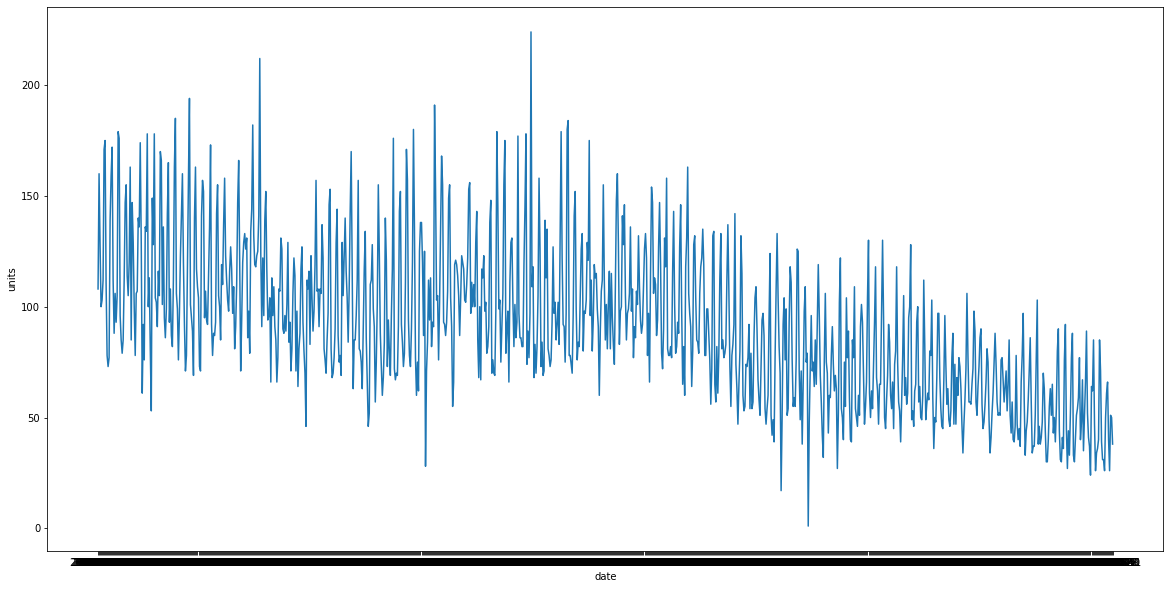

In [15]:
fig,ax1 = plt.subplots(nrows = 1,ncols = 1,figsize=(20,10))
sns.lineplot(x = "date", y = "units",data = max_grain, ax=ax1)

* Here in the above time series we can observe a trend. It's a decreasing one.
* It's difficult to observe straight-forward seasonality.
* This data is comprised of three years, let's just consider one of the years and see if we can look at any observable seasonality.
* We'll later conduct tests to look at seasonality.

### Test for stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller
def compute_dickey_fuller_test(x):
    if(isinstance(x,pd.Series) and x.empty == False):
        x.dropna(inplace = True)
        result = adfuller(x)
    if result[1] < 0.05 :
        return True
    else:
        return False  

In [17]:
print("Is time series stationary : {}".format(compute_dickey_fuller_test(max_grain['units'])))

Is time series stationary : False


#### Let's try to make it stationary by applying first order differencing

In [21]:
max_grain['first_order_diff'] = max_grain['units'].diff()
print("Is time series stationary : {}".format(compute_dickey_fuller_test(max_grain['first_order_diff'])))

Is time series stationary : True


<AxesSubplot:xlabel='date', ylabel='first_order_diff'>

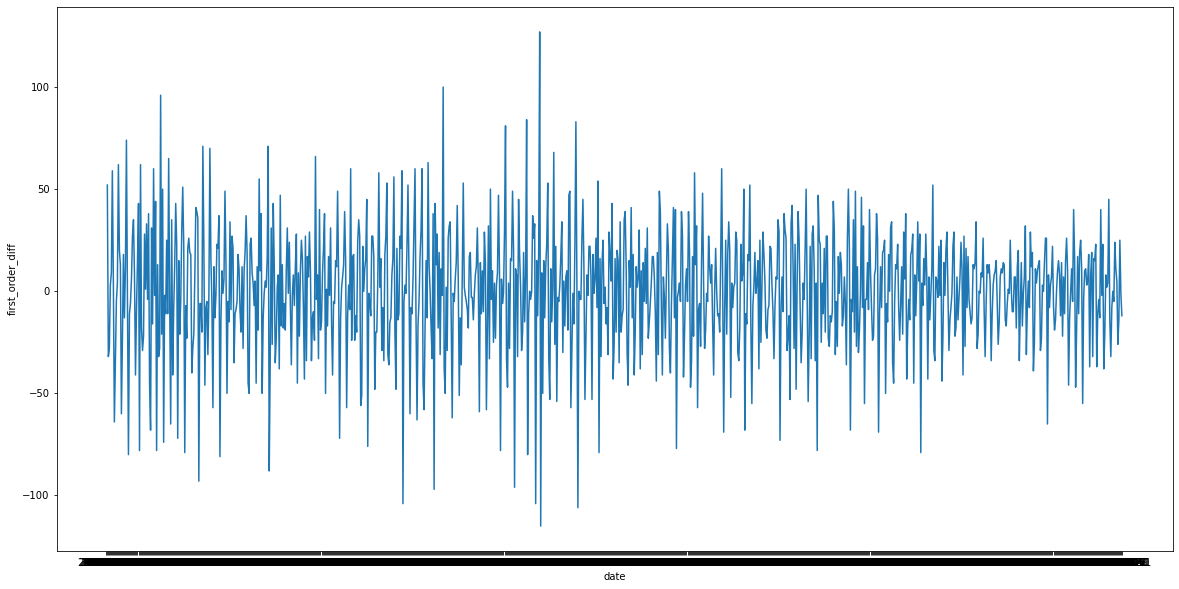

In [24]:
fig,ax1 = plt.subplots(nrows = 1,ncols = 1,figsize=(20,10))
sns.lineplot(x = "date", y = "first_order_diff",data = max_grain, ax=ax1)

* Mean looks constant over time.
* Some fluctuation in variance.
* Lines too jagged, seasonality can't be predicted.

<AxesSubplot:xlabel='units', ylabel='Density'>

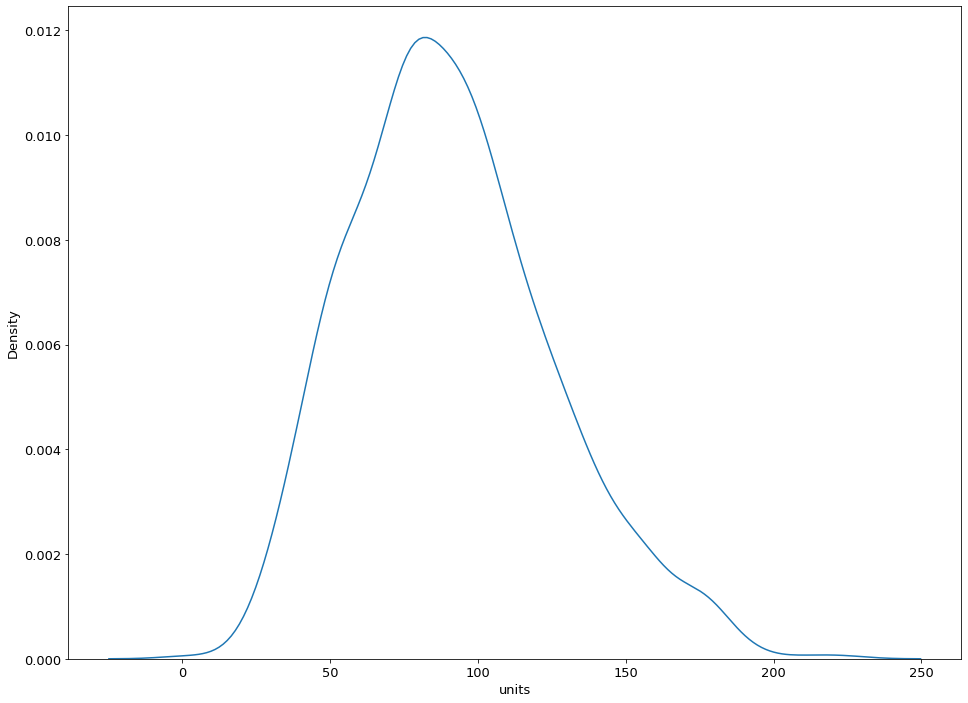

In [140]:
sns.kdeplot(max_grain['units'])

### Creating datetime features

In [29]:
def create_individual_date_cols(ts):
    # converting to datetime
    ts['date'] = pd.to_datetime(ts['date'])
    ts['day'] = ts.date.dt.day
    ts['wday'] = ts.date.dt.weekday
    ts['year'] = ts.date.dt.year
    ts['month'] = ts.date.dt.month
    ts['week'] = ts.date.dt.isocalendar().week
    return ts

In [30]:
max_grain = create_individual_date_cols(max_grain)

#### Looking at each year's units plot

<AxesSubplot:xlabel='date', ylabel='units'>

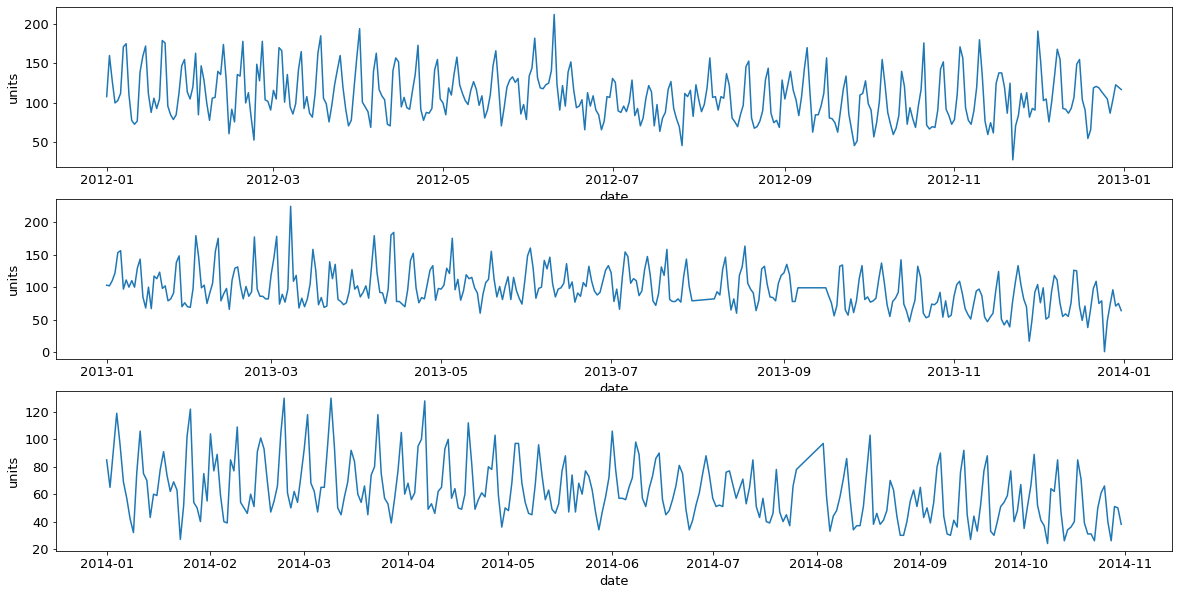

In [142]:
fig,((ax1),(ax2),(ax3)) = plt.subplots(nrows = 3,ncols = 1,figsize=(20,10))
sns.lineplot(x = "date", y = "units",data = max_grain[max_grain['year']==2012], ax=ax1)
sns.lineplot(x = "date", y = "units",data = max_grain[max_grain['year']==2013], ax=ax2)
sns.lineplot(x = "date", y = "units",data = max_grain[max_grain['year']==2014], ax=ax3)

* No visual observation of trend in broken pieces.

### Let's apply STL decomposition on these pieces of data(units sold in each year on a daily basis)

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

#### STL decomposition for 2012 data with period = 7

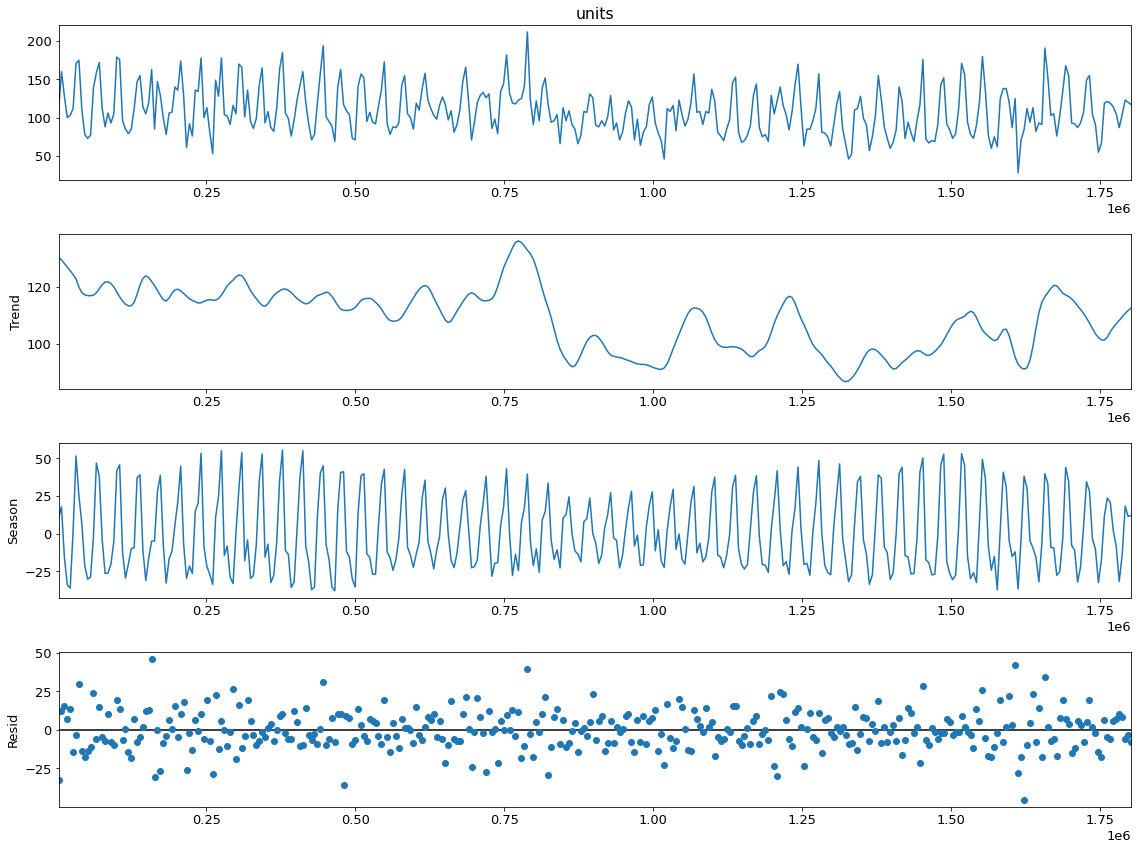

In [31]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

stl = STL(max_grain[max_grain['year']==2012]['units'],period=7)
res = stl.fit()
fig = res.plot()

* Trend is not clear
* There is seasonality
* Residues are centred around 0.

#### STL decomposition for 2012 data with period = 30

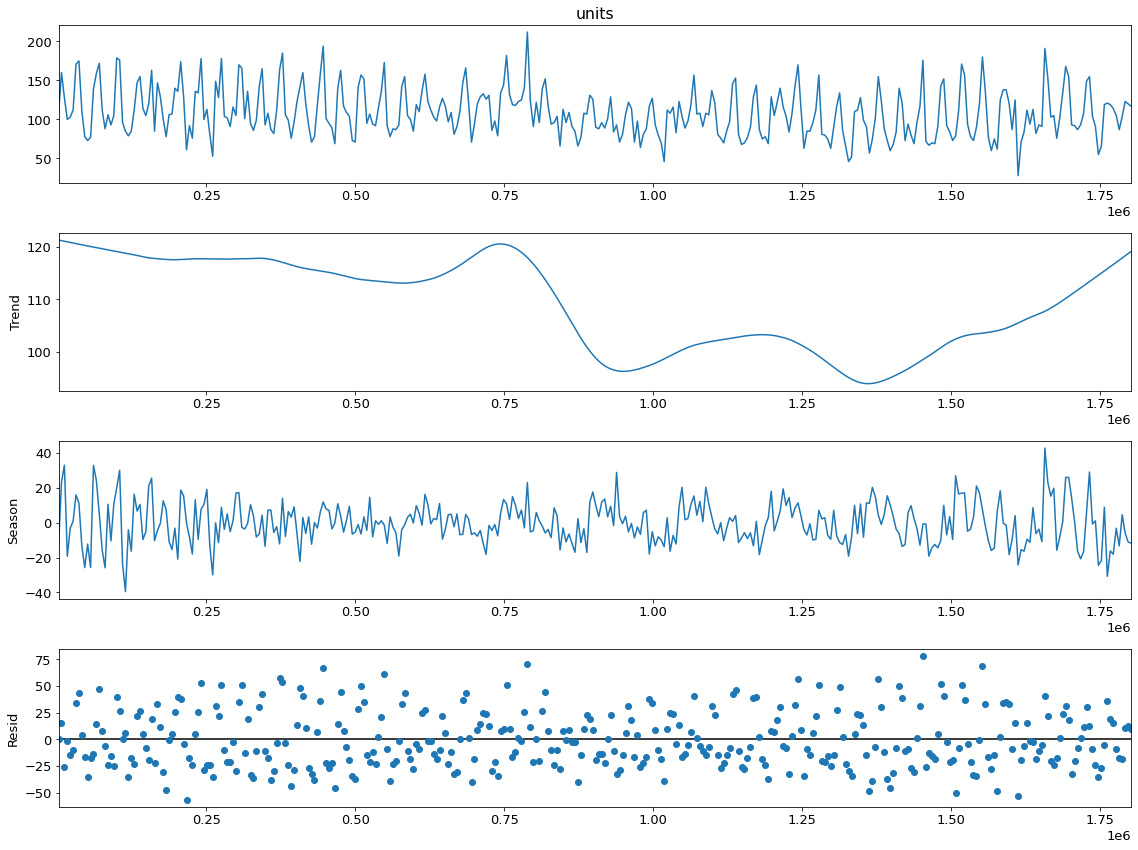

In [32]:
stl = STL(max_grain[max_grain['year']==2012]['units'],period=30)
res = stl.fit()
fig = res.plot()

* Trend line is smoothed out here, it shows decreasing trend followed by some plateau and then an increase.
* Seasonality can be observed but it's not that clear as seen in a period of 7 days.
* Residues are centred around 0 with a deviation/variance of 50.

### Trend Seasonal decomposition on the entire max_grain data

### period = 7

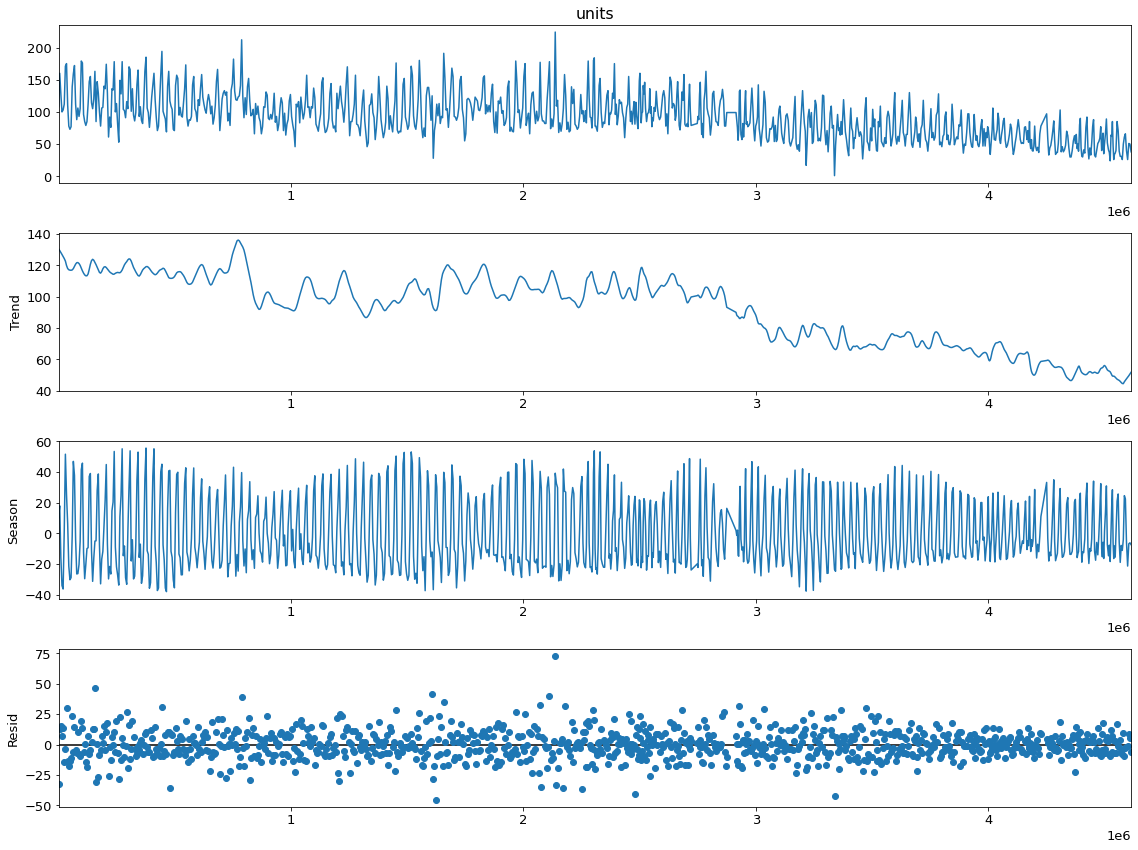

In [33]:
stl = STL(max_grain['units'],period=7)
res = stl.fit()
fig = res.plot()

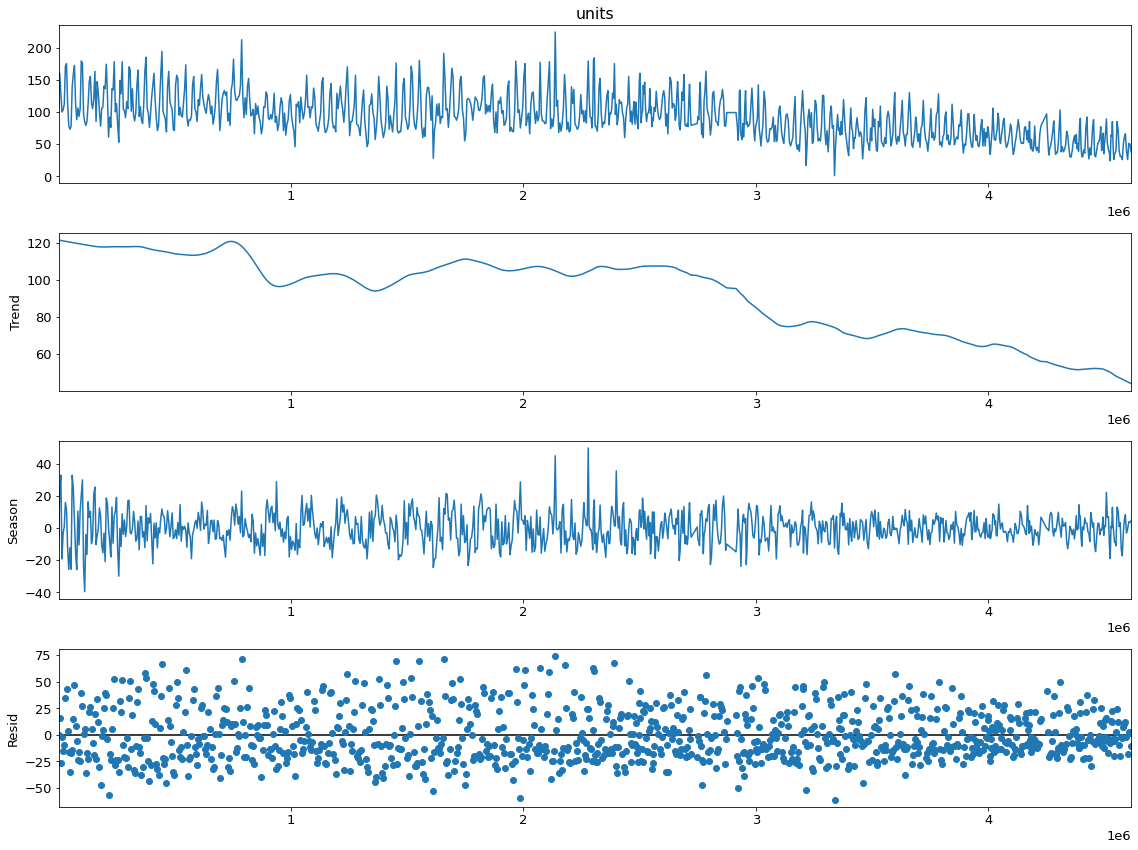

In [34]:
stl = STL(max_grain['units'],period=30)
res = stl.fit()
fig = res.plot()

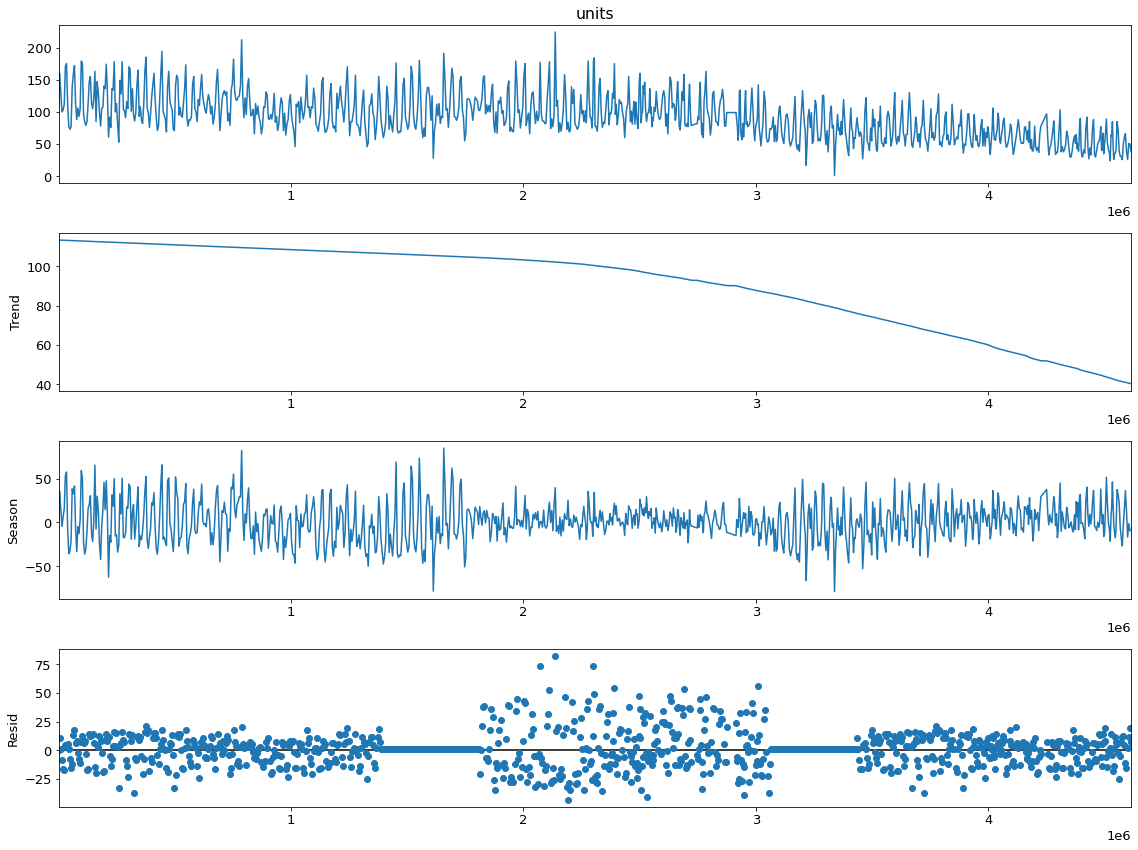

In [35]:
stl = STL(max_grain['units'],period=365)
res = stl.fit()
fig = res.plot()

### Let's first try simple autoregression

* Let's see if there is auto-correlation between the lags t and t+1
* Doing a visual test first using the lagplot

### Lag Plots

In [36]:
from pandas.plotting import lag_plot

In [37]:
series = max_grain['units']

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

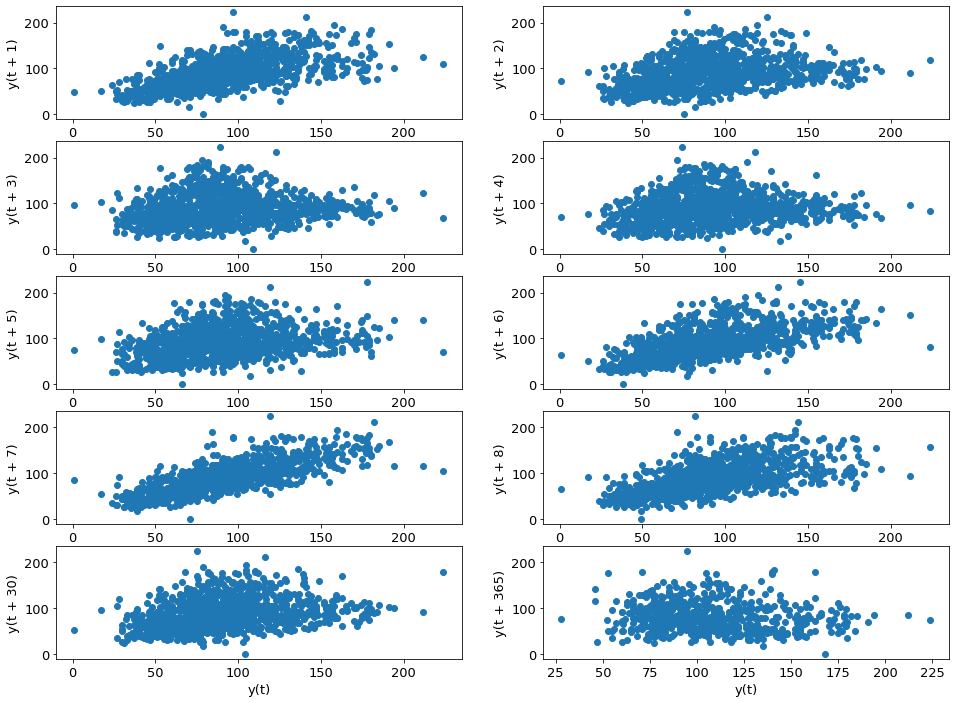

In [38]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10)) = plt.subplots(5,2)
lag_plot(series,lag=1,ax=ax1)
lag_plot(series,lag=2,ax=ax2)
lag_plot(series,lag=3,ax=ax3)
lag_plot(series,lag=4,ax=ax4)
lag_plot(series,lag=5,ax=ax5)
lag_plot(series,lag=6,ax=ax6)
lag_plot(series,lag=7,ax=ax7)
lag_plot(series,lag=8,ax=ax8)
lag_plot(series,lag=30,ax=ax9)
lag_plot(series,lag=365,ax=ax10)

Lag 7 seems to be the most promising showing some linear correlation

### Pearson correlation test

In [39]:
values = pd.DataFrame(max_grain['units'].values)
dataframe = pd.concat([values.shift(1),values.shift(2),values.shift(3),values.shift(4),values.shift(5),values.shift(6),values.shift(7), values], axis=1)
dataframe.columns = ['t-1','t-2','t-3','t-4','t-5','t-6','t-7','t']
result = dataframe.corr()['t']

In [40]:
result

t-1    0.613617
t-2    0.303114
t-3    0.108986
t-4    0.117899
t-5    0.302897
t-6    0.600037
t-7    0.772842
t      1.000000
Name: t, dtype: float64

Time lag t-7 shows some linear correlation with the t

### PACF Plot

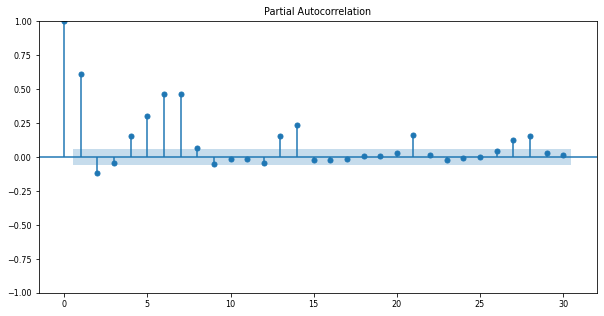

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure", figsize=(10, 5))
plt.rc("font", size=8)
plot_pacf(max_grain['units'], lags=30)
plt.show()

### ACF Plot

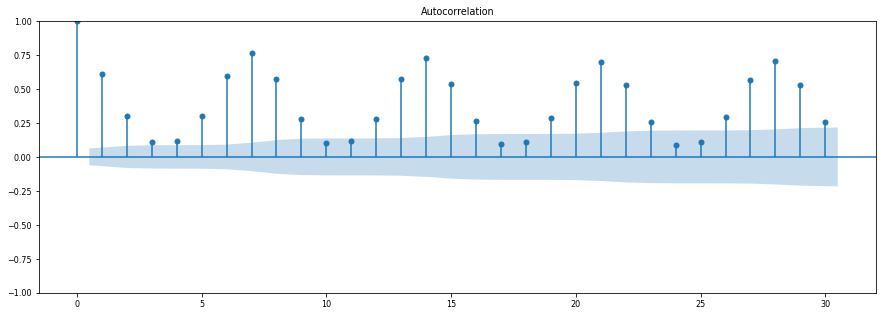

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
plt.rc("figure", figsize=(15, 5))
plt.rc("font", size=8)
plot_acf(max_grain['units'], lags=30)
plt.show()

### Train a AutoRegressor based on 7th time lag

In [43]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import math

In [44]:
# split dataset
# Doing a 80:20 split of train and test
X = list(max_grain['units'].values)
train_len = math.floor(0.9*len(X))
train, test = X[1:train_len], X[train_len:]

In [45]:
# train autoregression
model = AutoReg(train, lags=7)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 1.06435451e+01  2.71314045e-01 -5.32583710e-03 -6.03566043e-02
 -6.98566820e-03 -2.64246608e-03  2.27052726e-01  4.61528159e-01]


In [46]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 36.094


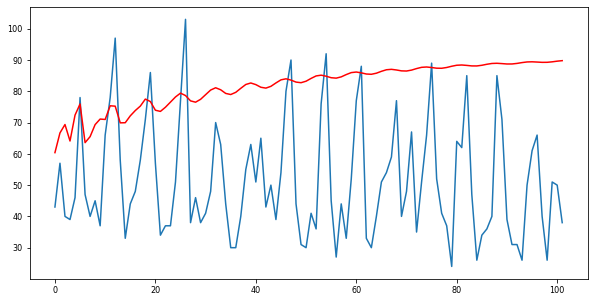

In [47]:
# plot results
plt.rc("figure", figsize=(10, 5))
plt.rc("font", size=8)

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

* Here in the above plot it can be seen that Autoregressor is able to capture the seasonality but the error is low initially and eventually becomes high and as the timeline increases it becomes a straight line with the prediction approaching a mean value.
* So it can be understood that we need to reduce the error and also see if we can reduce the mean line adjustment.

### Rolling forecast approach

In [49]:
rolling_predictions = []
for i in range(len(test)):
    pred_val = model_fit.predict(start=1, end=1, dynamic=False)
    rolling_predictions.append(pred_val)
    train.append(pred_val)
    model = AutoReg(train, lags=7)
    model_fit = model.fit()

In [50]:
rmse = math.sqrt(mean_squared_error(test, rolling_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 38.830


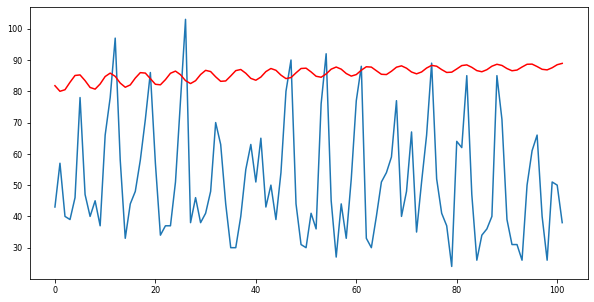

In [51]:
pyplot.plot(test)
pyplot.plot(rolling_predictions, color='red')
pyplot.show()

A better output and a better RMSE but still not satisfactory.

* Steps to follow
    * Make the data stationary(By removing trend and seasonality)
    * Get the threshold ACF PACF values to decide the grid seed for trend part.
    * Build a ARIMA model with grid search for hyper-parameter tuning.
    * Get the threshold ACF PACF values to decide the grid seed for seasonal part.
    * Build a SARIMA model with grid search for hyper-parameter tuning.

* A Time series is said to be stationary if the following conditions are satisfied.
    * Time series has constant mean.
    * Time series has constant variance.
    * Time series doesn't have seasonality component.
* After making the time series stationary, we are actually dealing with residues.

* Below piece of code is taken from machine learning mastery.
* It tries to automate the entire process of forecasting by learning for a set of hyper-paramters
* Selecting the best SARIMA configuration.
* But for a single grain itself it's taking about 2 hours to train, as the number of hyper-parameters to train are too high.
* And this is for just one single grain, whereas we need to train it for 255 such non-zero grains.
* So we'll be dropping this method to build the model.

In [173]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg,debug=True) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 7]
	d_params = [0, 1]
	q_params = [0, 1, 7]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 7]
	D_params = [0, 1, 7]
	Q_params = [0, 1, 7]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

if __name__ == '__main__':
	# define dataset
	data = max_grain['units']
	data_len = len(data)
	train_len = math.floor(len(data)*0.9)
	test_len = data_len - train_len
	# data split
	n_test = test_len
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

KeyboardInterrupt: 